In [50]:
import os
import torch
import time
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import (Dataset, DataLoader, random_split)
from torch.utils.data import DataLoader
import pandas as pd
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics import Accuracy
import test_lib
from importlib import reload
from torch.nn import functional as F
reload(test_lib)
import warnings
warnings.filterwarnings('ignore')

In [32]:
train_transforms = transforms.Compose([
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Grayscale(),
])

train_data = datasets.ImageFolder('train', transform=train_transforms, is_valid_file=lambda x: os.path.splitext(x)[1] in ['.jpg', '.jpeg', '.png'])
test_data = datasets.ImageFolder('test', transform=train_transforms, is_valid_file=lambda x: os.path.splitext(x)[1] in ['.jpg', '.jpeg', '.png'])

print("Training dataset: %d" % len(train_data))
print("Test dataset: %d" % len(test_data))

Training dataset: 4011
Test dataset: 1000


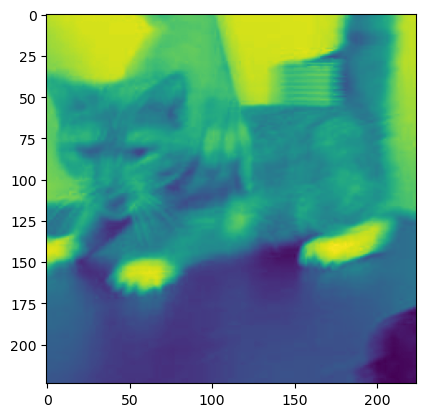

In [33]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
data, label = train_data[0]
plt.imshow(np.transpose(data, (1, 2, 0)))

In [53]:
class DeepCNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding='same'),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding='same'),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding='same'),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding='same'),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.LazyLinear(50),
            nn.ReLU(),
            nn.LazyLinear(2),
        )
        
    def forward(self, x):
        return self.model(x)

In [54]:
model = DeepCNNModel()
dataloader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4)
xs, targets = next(iter(dataloader))
model(xs).shape

torch.Size([128, 2])

In [61]:
def train(model: DeepCNNModel,
          train_dataset: Dataset,
          epochs: int, 
          max_batches=None) -> pd.DataFrame:
    
    train_loader = DataLoader(train_dataset, batch_size=max_batches, shuffle=True)
    accuracy = Accuracy(task='binary', num_classes=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    loss_fn = torch.nn.CrossEntropyLoss() 
    history = {
        'train_loss': [],
        'train_acc': [],
    }
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        
        start_time = time.time()
        
        for i, (inputs, targets) in enumerate(train_loader):
            inputs.to(torch.device('cuda'))
            targets.to(torch.device('cuda'))
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs.to(torch.device('cuda'))
            batch_loss = loss_fn(outputs, targets)
            batch_loss.backward()
            optimizer.step()
            
            train_loss += batch_loss.item()
            train_acc += accuracy(outputs.argmax(dim=1), targets).item()
        
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        end_time = time.time() 
        elapsed_time = end_time - start_time 
        
        print(f'Epoch {epoch+1}/{epochs} - ' f'Loss: {train_loss:.4f},' f'Accuracy: {train_acc:.4f},' f'Time: {elapsed_time:.2f}s')
    
    return pd.DataFrame(history)

In [62]:

hist = train(model, train_data, epochs=20, max_batches=128)

Epoch 1/20 - Loss: 0.6731,Accuracy: 0.5880,Time: 61.61s
Epoch 2/20 - Loss: 0.6483,Accuracy: 0.6288,Time: 52.90s
Epoch 3/20 - Loss: 0.6449,Accuracy: 0.6324,Time: 60.16s
Epoch 4/20 - Loss: 0.6196,Accuracy: 0.6505,Time: 59.99s
Epoch 5/20 - Loss: 0.6129,Accuracy: 0.6627,Time: 59.88s
Epoch 6/20 - Loss: 0.5884,Accuracy: 0.6876,Time: 59.79s
Epoch 7/20 - Loss: 0.5675,Accuracy: 0.7034,Time: 60.48s
Epoch 8/20 - Loss: 0.5391,Accuracy: 0.7286,Time: 65.98s
Epoch 9/20 - Loss: 0.5220,Accuracy: 0.7384,Time: 64.73s
Epoch 10/20 - Loss: 0.5014,Accuracy: 0.7633,Time: 63.93s
Epoch 11/20 - Loss: 0.4742,Accuracy: 0.7671,Time: 63.86s
Epoch 12/20 - Loss: 0.4543,Accuracy: 0.7823,Time: 63.46s
Epoch 13/20 - Loss: 0.4374,Accuracy: 0.7930,Time: 63.73s
Epoch 14/20 - Loss: 0.3744,Accuracy: 0.8399,Time: 63.83s
Epoch 15/20 - Loss: 0.3415,Accuracy: 0.8479,Time: 64.54s
Epoch 16/20 - Loss: 0.2978,Accuracy: 0.8750,Time: 63.69s
Epoch 17/20 - Loss: 0.2744,Accuracy: 0.8855,Time: 65.31s
Epoch 18/20 - Loss: 0.2230,Accuracy: 0.9

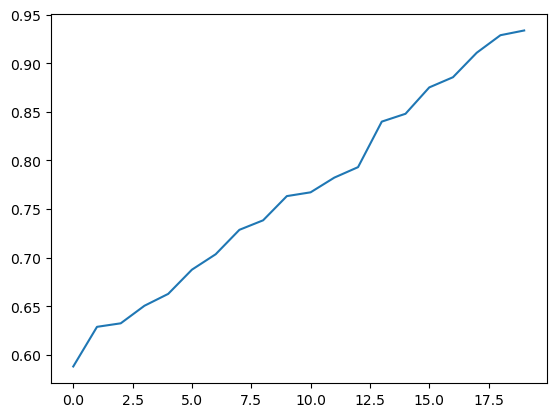

In [63]:
hist.train_acc.plot.line();

In [64]:
print(hist)

    train_loss  train_acc
0     0.673080   0.588004
1     0.648284   0.628781
2     0.644938   0.632398
3     0.619645   0.650470
4     0.612903   0.662666
5     0.588388   0.687579
6     0.567545   0.703432
7     0.539145   0.728555
8     0.522020   0.738355
9     0.501419   0.763252
10    0.474236   0.767135
11    0.454254   0.782261
12    0.437359   0.793037
13    0.374436   0.839866
14    0.341492   0.847923
15    0.297817   0.875034
16    0.274357   0.885521
17    0.222955   0.910690
18    0.182227   0.928739
19    0.169802   0.933605


In [65]:
torch.save(model, 'mymodel.pt')

In [67]:
test_lib.test_saved_model()

Loading from mymodel.pt
Saved model has test accuracy = 69.90


## This model has a test accuracy of approxiamtely 70%